# Data Project for NYC Taxi Dataset

Author: TianlinShan

E-mail: ts4271@nyu.edu

Date: May 21, 2022

Course: Machine Learning and Algorithms for Computational Social Science, Section 001

## Introduction

Tipping behavior of people is interesting. This project is to use public data of NYC taxi to analyze the factors that <br>may impact on tip amount. The factors might be trip duration, trip distance, passengers’ numbers, different <br>boroughs, different hours of a day, different days of a week, weather conditions and so on. How can these impact on tipping a driver? <br>This project will use analytical tools to specify it and visualize it to tell people some interesting trends. <br>Also, this project will use multiple machine learning model to do prediction and classification of tipping.

In [223]:
# Import libraries
import numpy as np
import pandas as pd
import time  
import pickle as pickle  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn import metrics 
%matplotlib inline

Taxi Data Source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
<br>The data was published by the NYC Taxi and Limousine Commission (TLC) and can be
downloaded from the Data Sourse that is shown above.
<br>The data I use is NYC Yellow taxi dataset of February, 2022.

Taxi Data Dictionary: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
<br>Use the Data Dictionary, then you can realize how each feature works in the dataset.
<br>Also, I have built a feature definition next, you can scroll down to the middle to see it.

Weather Data Source: https://www.visualcrossing.com/weather/weather-data-services

Taxi Zone Data Source: https://drive.google.com/drive/folders/1n3ZQu7KfMLyj6H7eIGw3vURnTx02G5Hi?usp=sharing

## Load Data

In [170]:
df1 = pd.read_csv('yellow_tripdata_2022-02.csv', low_memory=False)

In [172]:
df2 = pd.read_csv('NYC_Feb_weather.csv')

In [175]:
df3 = pd.read_csv('taxi_zone_lookup.csv')

In [192]:
df1['tpep_pickup_datetime']=pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime']=pd.to_datetime(df1['tpep_dropoff_datetime'])
df1['date_hour'] = df1['tpep_pickup_datetime'].dt.hour
df1['date'] = df1['tpep_pickup_datetime'].dt.date
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['date_hour'] = df2['datetime'].dt.hour
df2['date'] = df2['datetime'].dt.date
df_merge = pd.merge(df1,df2,left_on=['date','date_hour'], right_on=['date','date_hour'])
df = pd.merge(df_merge, df3, left_on='PULocationID', right_on='LocationID')

In [193]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,date_hour,date,datetime,temp,conditions,icon,LocationID,Borough,Zone,service_zone
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,...,0,2022-02-01,2022-02-01,25.0,Clear,clear-night,138,Queens,LaGuardia Airport,Airports
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,...,0,2022-02-01,2022-02-01,25.0,Clear,clear-night,138,Queens,LaGuardia Airport,Airports
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,...,0,2022-02-01,2022-02-01,25.0,Clear,clear-night,138,Queens,LaGuardia Airport,Airports
3,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,...,0,2022-02-01,2022-02-01,25.0,Clear,clear-night,138,Queens,LaGuardia Airport,Airports
4,2,2022-02-01 00:23:16,2022-02-01 00:40:53,1.0,11.77,1.0,N,138,132,1,...,0,2022-02-01,2022-02-01,25.0,Clear,clear-night,138,Queens,LaGuardia Airport,Airports


In [180]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date_hour,temp,LocationID
count,2979367.00,2877629.00,2979367.00,2877629.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2979367.00,2877629.00,2979367.00,2979367.00,2979367.00
mean,1.71,1.39,5.85,1.42,165.53,163.43,1.17,13.13,1.02,0.49,2.50,0.38,0.30,19.50,2.31,14.21,38.29,165.53
std,0.50,0.98,642.54,6.02,65.61,70.42,0.50,12.05,1.23,0.08,2.79,1.67,0.04,14.95,0.71,5.70,10.97,65.61
min,1.00,0.00,0.00,1.00,1.00,1.00,0.00,-600.00,-4.50,-0.50,-188.00,-29.05,-0.30,-600.30,-2.50,0.00,16.50,1.00
25%,1.00,1.00,1.08,1.00,132.00,113.00,1.00,6.50,0.00,0.50,1.00,0.00,0.30,11.76,2.50,11.00,30.30,132.00
50%,2.00,1.00,1.79,1.00,162.00,162.00,1.00,9.50,0.50,0.50,2.06,0.00,0.30,15.30,2.50,15.00,36.20,162.00
75%,2.00,1.00,3.20,1.00,234.00,234.00,1.00,14.50,2.50,0.50,3.15,0.00,0.30,20.80,2.50,19.00,45.20,234.00
max,6.00,9.00,348798.53,99.00,265.00,265.00,5.00,655.35,10.30,3.30,380.80,95.00,0.30,656.15,2.75,23.00,68.20,265.00


we can see that there are outliers. We will do drop outliers and data cleaning after feature selection.

## Feature Selection

<AxesSubplot:>

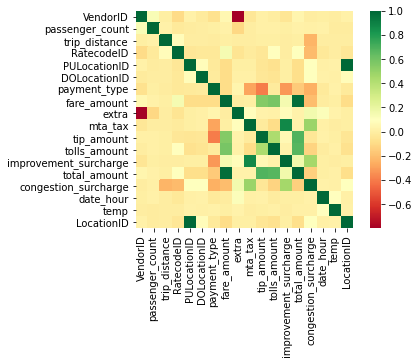

In [181]:
# Create a heatmap
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

We drop all columns that has no linear relationship with tip ammount, except some comlumns which will be used to do feature engineering and we hope they can have a linear relationship with tip amount.

In [224]:
# Features we want to explore
column_names = ['tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance','RatecodeID','payment_type',
                'fare_amount','total_amount','tip_amount','date_hour', 'temp', 'icon','Borough']
df_taxi = df[column_names]
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,payment_type,fare_amount,total_amount,tip_amount,date_hour,temp,icon,Borough
0,2022-02-01 00:06:58,2022-02-01 00:19:24,5.40,1.0,1,17.0,23.45,3.90,0,25.0,clear-night,Queens
1,2022-02-01 00:38:22,2022-02-01 00:55:55,6.40,1.0,2,21.0,30.10,0.00,0,25.0,clear-night,Queens
2,2022-02-01 00:03:20,2022-02-01 00:26:59,12.50,1.0,2,35.5,44.60,0.00,0,25.0,clear-night,Queens
3,2022-02-01 00:06:48,2022-02-01 00:33:07,12.16,1.0,1,35.5,48.66,8.11,0,25.0,clear-night,Queens
4,2022-02-01 00:23:16,2022-02-01 00:40:53,11.77,1.0,1,32.0,41.21,6.66,0,25.0,clear-night,Queens


## Feture Engineering

In [225]:
df_taxi = df_taxi[df_taxi['payment_type'] == 1] # 1 here means paid by credit card. 
                                            #Tip_amount appears when paid by credit card(check Data Dictionary)
#Create Feature: trip duration in minutes
df_taxi['trip_duration'] = df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']
df_taxi['trip_duration'] = df_taxi['trip_duration'].astype('timedelta64[m]')
#Create Feature: trip speed in m/h
df_taxi['trip_speed'] = df_taxi['trip_distance']/(df_taxi['trip_duration']/60)
#Create Feature: tip rate in percent
df_taxi['tip_rate'] = (df_taxi['tip_amount']/df_taxi['total_amount'])*100
#Drop column payment_type as we've used payment type is 1 already
#Drop column RatecodeID as all RatecodeID is 1 after droping outliers
df_taxi = df_taxi.drop('payment_type', axis = 1)

In [226]:
#Create Features: pickup_hour, dropoff_hour, dayOfWeek
df_taxi['pickup_hour'] = df_taxi['tpep_pickup_datetime'].dt.hour
df_taxi['dropoff_hour'] = df_taxi['tpep_dropoff_datetime'].dt.hour
df_taxi['dayOfWeek'] = df_taxi['tpep_dropoff_datetime'].dt.day_name()

## Drop outliers

In [227]:
df_taxi = df_taxi[df_taxi['fare_amount'] > 0]
df_taxi = df_taxi[df_taxi['total_amount'] > 0]# Amount should be higher than 0
df_taxi = df_taxi[df_taxi['trip_speed'] < 100]
df_taxi = df_taxi[df_taxi['trip_speed'] > 0]
# use 3<z-score < 3 to filter data
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['trip_distance'])) < 3)]
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['fare_amount'])) < 3)]
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['total_amount'])) < 3)]
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['RatecodeID'])) < 3)] 
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['tip_amount'])) < 3)] 
df_taxi = df_taxi[(np.abs(stats.zscore(df_taxi['tip_rate'])) < 3)]

## Data Cleaning 

In [228]:
# Check null values in all columns
df_taxi.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
trip_distance            0
RatecodeID               0
fare_amount              0
total_amount             0
tip_amount               0
date_hour                0
temp                     0
icon                     0
Borough                  0
trip_duration            0
trip_speed               0
tip_rate                 0
pickup_hour              0
dropoff_hour             0
dayOfWeek                0
dtype: int64

Good. We got no nulls.

In [229]:
# Check duplicates
duplicates = df_taxi[df_taxi.duplicated(keep = 'first')]
duplicates.sort_values(by=['RatecodeID'], ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,fare_amount,total_amount,tip_amount,date_hour,temp,icon,Borough,trip_duration,trip_speed,tip_rate,pickup_hour,dropoff_hour,dayOfWeek
349430,2022-02-09 12:15:27,2022-02-09 12:26:55,1.5,1.0,9.0,14.75,2.45,12,41.4,clear-day,Manhattan,11.0,8.181818,16.610169,12,12,Wednesday


In [230]:
# Drop all duplicates 
df_taxi.drop_duplicates(inplace = True)

In [231]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,fare_amount,total_amount,tip_amount,date_hour,temp,icon,Borough,trip_duration,trip_speed,tip_rate,pickup_hour,dropoff_hour,dayOfWeek
0,2022-02-01 00:06:58,2022-02-01 00:19:24,5.40,1.0,17.0,23.45,3.90,0,25.0,clear-night,Queens,12.0,27.000000,16.631130,0,0,Tuesday
6,2022-02-01 00:05:33,2022-02-01 00:25:57,10.16,1.0,29.5,38.46,6.41,0,25.0,clear-night,Queens,20.0,30.480000,16.666667,0,0,Tuesday
7,2022-02-01 00:14:06,2022-02-01 00:31:56,10.33,1.0,29.0,37.61,6.06,0,25.0,clear-night,Queens,17.0,36.458824,16.112736,0,0,Tuesday
9,2022-02-01 00:32:38,2022-02-01 00:42:45,4.60,1.0,14.5,19.55,2.50,0,25.0,clear-night,Queens,10.0,27.600000,12.787724,0,0,Tuesday
12,2022-02-01 00:11:02,2022-02-01 00:23:50,7.72,1.0,22.0,29.46,4.91,0,25.0,clear-night,Queens,12.0,38.600000,16.666667,0,0,Tuesday


Now the df_taxi data is cleaned without null, dupilactes and outliers.

### Check all features that will be categorized

Convert objects to Category

In [302]:
df_taxi['RatecodeID'] = df_taxi['RatecodeID'].astype('category')

In [303]:
df_taxi['RatecodeID'].describe()

count     1994273.0
unique          4.0
top             1.0
freq      1993536.0
Name: RatecodeID, dtype: float64

In [206]:
np.sort(df_taxi['Borough'].unique())

array(['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island',
       'Unknown'], dtype=object)

In [235]:
df_taxi['Borough'] = df_taxi['Borough'].astype('category')
df_taxi['Borough'].describe()

count       1994273
unique            7
top       Manhattan
freq        1954366
Name: Borough, dtype: object

In [245]:
df_taxi['icon'] = df_taxi['icon'].astype('category')
df_taxi['icon'].describe()

count       1994273
unique            8
top       clear-day
freq         407228
Name: icon, dtype: object

In [247]:
df_taxi['dayOfWeek'] = df_taxi['dayOfWeek'].astype('category')
df_taxi['dayOfWeek'].describe()

count      1994273
unique           7
top       Saturday
freq        323771
Name: dayOfWeek, dtype: object

In [248]:
df_taxi['date_hour'] = df_taxi['date_hour'].astype('category')
df_taxi['date_hour'].describe()

count     1994273
unique         24
top            18
freq       159174
Name: date_hour, dtype: int64

In [279]:
df_taxi['speed_level'] = df_taxi['speed_level'].astype('category')
df_taxi['speed_level'].describe()

count       1994273
unique            3
top       Low Speed
freq        1077107
Name: speed_level, dtype: object

In [236]:
df_taxi.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,trip_distance,fare_amount,total_amount,tip_amount,date_hour,temp,trip_duration,trip_speed,tip_rate,pickup_hour,dropoff_hour
count,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00,1994273.00
mean,2.11,10.17,16.36,2.58,14.38,38.29,12.48,11.56,15.79,14.38,14.44
std,1.53,4.90,5.84,1.13,5.67,10.92,39.03,4.91,3.97,5.67,5.75
min,0.01,1.50,3.88,0.05,0.00,16.50,1.00,0.01,0.60,0.00,0.00
25%,1.07,6.50,12.25,1.86,11.00,30.30,6.00,8.36,14.78,11.00,11.00
50%,1.68,9.00,14.80,2.36,15.00,36.20,10.00,10.58,16.67,15.00,15.00
75%,2.64,12.50,18.96,3.16,19.00,45.20,15.00,13.63,16.67,19.00,19.00
max,14.80,33.00,40.02,6.59,23.00,68.20,1439.00,94.80,30.09,23.00,23.00


### tip rate engineering

In [276]:
# convert tip rate into levels for furture classication
def get_tip_level(tip_rate):
    if tip_rate < 15:
        return 'Low'
    elif tip_rate < 18:
        return 'Medium'
    else:
        return 'High' 
#Convert trip speed into levels for future model
def get_speed_level(trip_speed):
    if trip_speed <11:
        return 'Low Speed'
    elif trip_speed < 20:
        return 'Medium Speed'
    else:
        return 'Higher Speed'

In [277]:
df_taxi['tip_level'] = df_taxi['tip_rate'].apply(lambda x: get_tip_level(x))
df_taxi['speed_level'] = df_taxi['trip_speed'].apply(lambda x: get_speed_level(x))

In [278]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,fare_amount,total_amount,tip_amount,date_hour,temp,icon,Borough,trip_duration,trip_speed,tip_rate,pickup_hour,dropoff_hour,dayOfWeek,tip_level,speed_level
0,2022-02-01 00:06:58,2022-02-01 00:19:24,5.40,1.0,17.0,23.45,3.90,0,25.0,clear-night,Queens,12.0,27.000000,16.631130,0,0,Tuesday,Medium,Higher Speed
6,2022-02-01 00:05:33,2022-02-01 00:25:57,10.16,1.0,29.5,38.46,6.41,0,25.0,clear-night,Queens,20.0,30.480000,16.666667,0,0,Tuesday,Medium,Higher Speed
7,2022-02-01 00:14:06,2022-02-01 00:31:56,10.33,1.0,29.0,37.61,6.06,0,25.0,clear-night,Queens,17.0,36.458824,16.112736,0,0,Tuesday,Medium,Higher Speed
9,2022-02-01 00:32:38,2022-02-01 00:42:45,4.60,1.0,14.5,19.55,2.50,0,25.0,clear-night,Queens,10.0,27.600000,12.787724,0,0,Tuesday,Low,Higher Speed
12,2022-02-01 00:11:02,2022-02-01 00:23:50,7.72,1.0,22.0,29.46,4.91,0,25.0,clear-night,Queens,12.0,38.600000,16.666667,0,0,Tuesday,Medium,Higher Speed


## Data Visulization

In [417]:
speed_grouped_df = df_taxi.groupby('speed_level')['tip_amount'].aggregate(np.mean).reset_index()
dHour_grouped_df = df_taxi.groupby('date_hour')['tip_amount'].aggregate(np.mean).reset_index()
dWeek_grouped_df = df_taxi.groupby('dayOfWeek')['tip_amount'].aggregate(np.mean).reset_index()
icon_grouped_df = df_taxi.groupby('icon')['tip_amount'].aggregate(np.mean).reset_index()
Borough_grouped_df = df_taxi.groupby('Borough')['tip_amount'].aggregate(np.mean).reset_index()
Ratecode_grouped_df = df_taxi.groupby('RatecodeID')['tip_amount'].aggregate(np.mean).reset_index()

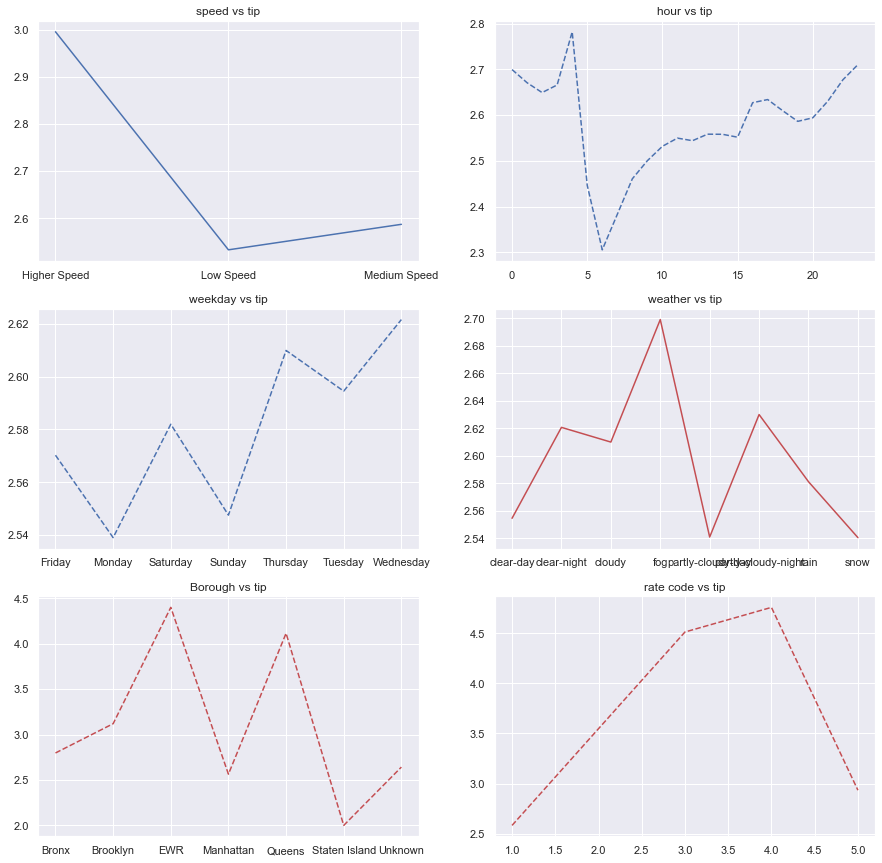

In [421]:
fig, ax = plt.subplots(3, 2,figsize=(15,15))

ax[0,0].plot(speed_grouped_df.speed_level.values,speed_grouped_df.tip_amount.values, color='b')
ax[0,0].set_title('speed vs tip')
ax[0,1].plot(dHour_grouped_df.date_hour.values,dHour_grouped_df.tip_amount.values, color='b', linestyle='--')
ax[0,1].set_title('hour vs tip')
ax[1,0].plot(dWeek_grouped_df.dayOfWeek.values,dWeek_grouped_df.tip_amount.values, color='b', linestyle='--')
ax[1,0].set_title('weekday vs tip')
ax[1,1].plot(icon_grouped_df.icon.values,icon_grouped_df.tip_amount.values, color='r')
ax[1,1].set_title('weather vs tip')
ax[2,0].plot(Borough_grouped_df.Borough.values,Borough_grouped_df.tip_amount.values, color='r', linestyle='--')
ax[2,0].set_title('Borough vs tip')
ax[2,1].plot(Ratecode_grouped_df.RatecodeID.values,Ratecode_grouped_df.tip_amount.values, color='r', linestyle='--')
ax[2,1].set_title('rate code vs tip')
plt.show()

We can see that these features have tremendous impact on tipping behavious. 
For example, At high speeds, tipping increases significantly.
<br>Tipping is the highest in the early morning and evening every day. In addition, during the morning rush hour, perhaps passengers are stuck in traffic jams, and tips have dropped significantly.
<br>A fun fact is that people pay more tips when it is fog.

## Feature description

<br>Trip distance: The elapsed trip distance in miles reported by the taximeter.
<br>Trip duration: The time difference between pick-up time and drop-off time.
<br>Fare amount: The time-and-distance fare calculated by the meter.
<br>Tolls amount: Total amount of all tolls paid in trip.
<br>Total amount: The total amount charged to passengers. Does not include cash tips.
<br>Passenger count: The number of passengers in the vehicle.
<br>Pick-up hour: The hour when the meter was engaged.
<br>Drop-off hour:  The hour when the meter was disengaged.
<br>Day of week: The day of week when the meter was engaged.
<br>icon: The weather condition grouped by hours.
<br>Borough: The five Boroughs of New York City.
<br>Tip rate: Tip amount divided by total fare.
<br>Tip amount: Tip amount. This field is automatically populated for credit card, so I have deleted all data when payment type is not “credit card”.

<AxesSubplot:>

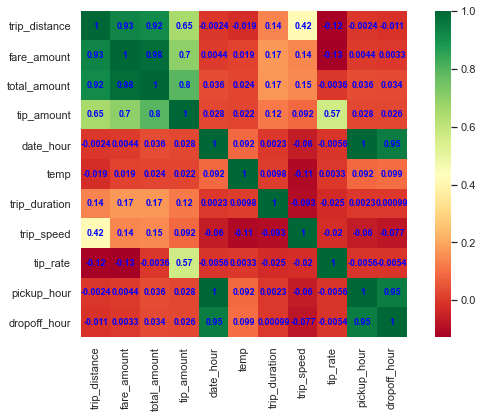

In [237]:
# Create a heatmap
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(df_taxi.corr(), square=True, annot=True, 
            annot_kws={'size':9,'weight':'bold', 'color':'blue'}, cmap='RdYlGn')

We can feagure out squares in hard red does not have a strong linear relationship with tip amount!

Below, we will delete those comluns, then we will build a linear regression model.

## Model Building

### Linear Regression to predict tip amount

In [304]:
reg_columns = ['trip_distance','fare_amount','total_amount','tip_amount']
df_taxi_reg = df_taxi[reg_columns]

In [306]:
dummies = ['RatecodeID','speed_level','icon','Borough','dayOfWeek','date_hour']
df_dummies = pd.get_dummies(df_taxi[dummies],drop_first=True)

In [307]:
df_taxi_reg.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,trip_distance,fare_amount,total_amount,tip_amount
count,1994273.00,1994273.00,1994273.00,1994273.00
mean,2.11,10.17,16.36,2.58
std,1.53,4.90,5.84,1.13
min,0.01,1.50,3.88,0.05
25%,1.07,6.50,12.25,1.86
50%,1.68,9.00,14.80,2.36
75%,2.64,12.50,18.96,3.16
max,14.80,33.00,40.02,6.59


In [309]:
df_taxi_reg = pd.concat([df_taxi_reg, df_dummies], axis=1)

In [334]:
X = df_taxi_reg.drop('tip_amount', axis = 1)
y = df_taxi_reg['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1111)

In [335]:
#Check if the X, y shape matches
print(X_train.shape)
print(y_train.shape)

(1336162, 50)
(1336162,)


In [336]:
# Create the regressor: l
l = LinearRegression()

# Fit the regressor to the training data
l.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = l.predict(X_test)

# Compute and print R^2 and RMSE for testing set
print("trian R^2: {}".format(l.score(X_train, y_train)))
print("test R^2: {}".format(l.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

trian R^2: 0.8483562336372562
test R^2: 0.8496861080601659
Root Mean Squared Error: 0.43939749745103795


The result looks good and by comparision I see no overfitting.

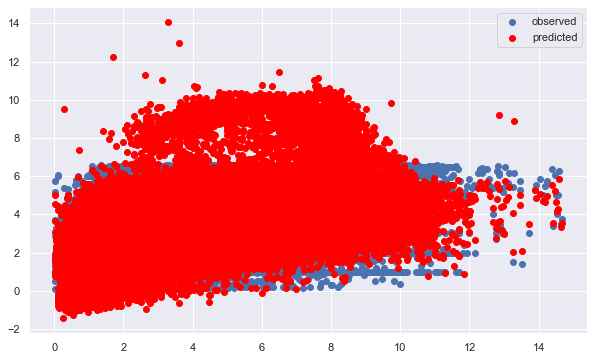

In [339]:
fig, ax = plt.subplots()
ax.scatter(X_test.iloc[:,0], y_test)
ax.scatter(X_test.iloc[:,0], y_pred, color = "red")
ax.legend(["observed", "predicted"])

### Random Forest Model to Predict Tip Amount

In [363]:
df_taxi_forest = df_taxi_reg.iloc[0:10000,:] # Use 10000 rows of data due to my old laptop's ability

In [364]:
X = df_taxi_forest.drop('tip_amount', axis = 1)
y = df_taxi_forest['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [365]:
# from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, y_train)

# Look at the R^2 scores on train and test
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9762463350831215
0.8098198236759222


test score is apparently smaller than the train score. It looks like the model has a problem by watching the result.

In [380]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [35], 'max_features': [4, 50], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train, y_train)
    test_scores.append(rfr.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8086386747676888 {'random_state': 42, 'n_estimators': 200, 'max_features': 50, 'max_depth': 35}


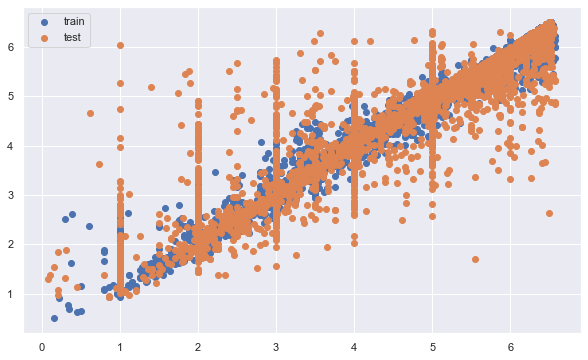

In [381]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=35, max_features=50, random_state=42)
rfr.fit(X_train, y_train)

# Make predictions with our model
train_predictions = rfr.predict(X_train)
test_predictions = rfr.predict(X_test)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(y_train, train_predictions, label='train')
plt.scatter(y_test, test_predictions, label='test')
plt.legend()
plt.show()

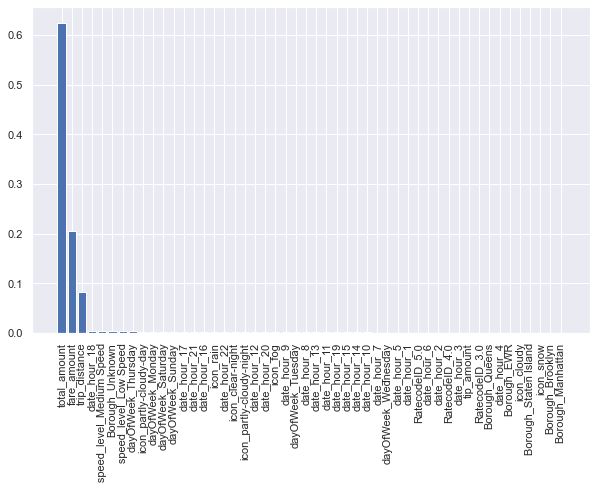

In [383]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(df_taxi_forest.columns)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

The result is extremely skewed. It looks an overfitting model, since so many features are less important.

However, as shown on Data visulization part, I truly believe those features are correlatitve to tip.

Our purpose is to predict how those factors impact on tip, so maybe we do not need to predict an accurate <br>tip amount. Next, I will use classification methods to predict tips.

## Model Selection For Classification to Predict tip Level

In [403]:
# Multinomial Naive Bayes Classifier  
def naive_bayes_classifier(train_x, train_y):  
    from sklearn.naive_bayes import MultinomialNB  
    model = MultinomialNB(alpha=0.01)  
    model.fit(train_x, train_y)  
    return model  
    
# KNN Classifier  
def knn_classifier(train_x, train_y):  
    from sklearn.neighbors import KNeighborsClassifier  
    model = KNeighborsClassifier()  
    model.fit(train_x, train_y)  
    return model  

# Random Forest Classifier  
def random_forest_classifier(train_x, train_y):  
    from sklearn.ensemble import RandomForestClassifier  
    model = RandomForestClassifier(n_estimators=200)  
    model.fit(train_x, train_y)  
    return model  
   
# Desision Tree Classifier  
def decision_tree_classifier(train_x, train_y):  
    from sklearn import tree  
    model = tree.DecisionTreeClassifier()  
    model.fit(train_x, train_y)  
    return model  
   
# GBDT(Gradient Boosting Decision Tree) Classifier  
def gradient_boosting_classifier(train_x, train_y):  
    from sklearn.ensemble import GradientBoostingClassifier  
    model = GradientBoostingClassifier(n_estimators=200)  
    model.fit(train_x, train_y)  
    return model  
   
# SVM Classifier  
def svm_classifier(train_x, train_y):  
    from sklearn.svm import SVC  
    model = SVC(kernel='rbf', probability=True)  
    model.fit(train_x, train_y)  
    return model   

In [405]:
#Reset training and testing data set
class_columns = ['trip_distance','fare_amount','total_amount','tip_level']
dummies = ['RatecodeID','speed_level','icon','Borough','dayOfWeek','date_hour']
df_dummies = pd.get_dummies(df_taxi[dummies],drop_first=True)
data = pd.concat([df_taxi[class_columns], df_dummies], axis=1)
data = data.iloc[0:5000,:]
X = data.drop('tip_level', axis = 1)
y = data['tip_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [408]:
#Impletment the models
def read_data(data):  
    train = X
    test = y
    train_y = y_train
    train_x = X_train
    test_y = y_test
    test_x = X_test
    return train_x, train_y, test_x, test_y
         
test_classifiers = ['NB', 'KNN', 'RF', 'DT', 'SVM', 'GBDT']  
classifiers = {'NB':naive_bayes_classifier,   
              'KNN':knn_classifier,  
               'RF':random_forest_classifier,  
               'DT':decision_tree_classifier,  
              'SVM':svm_classifier,  
             'GBDT':gradient_boosting_classifier  
}  

print('reading training and testing data...')  
train_x, train_y, test_x, test_y = read_data(data)  

for classifier in test_classifiers:  
    print('******************* %s ********************' % classifier)  
    start_time = time.time()  
    model = classifiers[classifier](train_x, train_y)  
    print('training took %fs!' % (time.time() - start_time)) 
    predict = model.predict(test_x)   
    precision = metrics.precision_score(test_y, predict,average='macro',labels=np.unique(predict))  
    recall = metrics.recall_score(test_y, predict,average='macro')  
    print('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))  
    accuracy = metrics.accuracy_score(test_y, predict)  
    print('accuracy: %.2f%%' % (100 * accuracy))

reading training and testing data...
******************* NB ********************
training took 0.101620s!
precision: 54.30%, recall: 33.75%
accuracy: 58.55%
******************* KNN ********************
training took 0.017278s!
precision: 67.00%, recall: 59.28%
accuracy: 70.06%
******************* RF ********************
training took 1.465466s!
precision: 60.72%, recall: 50.69%
accuracy: 65.88%
******************* DT ********************
training took 0.035280s!
precision: 72.75%, recall: 72.94%
accuracy: 76.30%
******************* SVM ********************
training took 5.236227s!
precision: 58.61%, recall: 33.33%
accuracy: 58.61%
******************* GBDT ********************
training took 3.619377s!
precision: 81.22%, recall: 68.24%
accuracy: 79.39%


Decision Tree Model and Gradient Boosting Decision Tree give us a good result.

## Conclusion

Tipping is a subjective behavior of customers. In theory, customers will only give better tips when they think they have received better service. Conversely, a bad consumer experience will get less tips. In the NYC yellow cab dataset, we can clearly observe that the biggest influence on tipping is the total cost. This goes without saying, as tips are always prorated based on the total cost. However, we must understand that the driving location, date hour, day of week, weather factors, and driving speed will all affect the passenger's ride experience, and ultimately cause the tip to fluctuate.

According to the summary of information, it can be judged that in New York City, in clear days, you will get better tips during non-morning peak hours. Based on these findings, taxi drivers can get better tips by avoiding traffic jams as much as possible. Hopefully these findings will be of some help to taxi drivers in planning routes.

In addition, in the process of creating the model, I found that it is difficult for our analysis to be perfect. This may be because the data features are not rich enough, and tipping is a subjective factor, which is difficult to analyze perfectly. If we could get more specific NYC information, maybe a better model could be created to predict tipping.